In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from geopack import geopack
import pyspedas
import sys
sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/')
from esn_dts_openloop import ESN, Tikhonov

In [4]:
nsteps=45792 #159 days * 24 hours* 12 (5min steps)

meanw=np.load('meanw.npy')
imgpcaw=np.load('imgw.npy')
datpcaw=np.load('pcaw.npy')

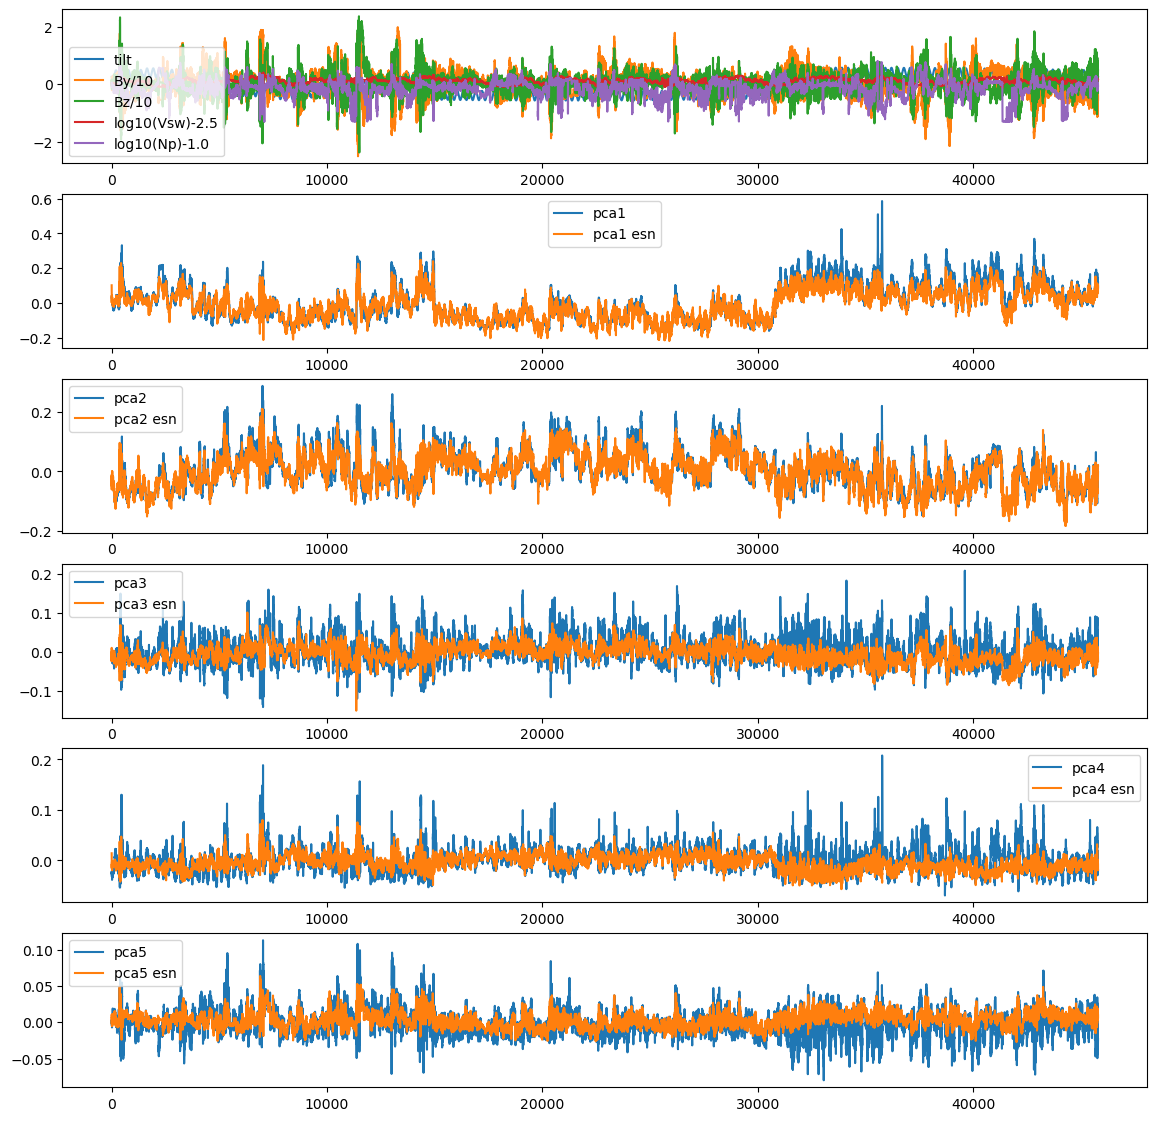

In [5]:
flearn=1e-3 #for sigma
data_d = datpcaw*flearn #output data

def read_sw_data(file_name):
    dataa = np.empty(0)
    datab = np.empty(0)
    datac = np.empty(0)
    datad = np.empty(0)
    datae = np.empty(0)
    dataf = np.empty(0)
    datag = np.empty(0)
    datah = np.empty(0)

    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tmp = line.split()
            dataa = np.hstack((dataa, float(tmp[0])))  # yy
            datab = np.hstack((datab, float(tmp[1])))  # mm
            datac = np.hstack((datac, float(tmp[2])))  # dd
            datad = np.hstack((datad, float(tmp[3])))  # hh
            datae = np.hstack((datae, float(tmp[4])))  # by
            dataf = np.hstack((dataf, float(tmp[5])))  # bz
            datag = np.hstack((datag, float(tmp[6])))  # log10vx-2.5
            datah = np.hstack((datah, float(tmp[7])))  # log10np-1.0

    return dataa,datab,datac,datad,datae,dataf,datag,datah

yy,mm,dd,hh,sw1,sw2,sw3,sw4 = read_sw_data(file_name='swall3_5min.txt') #y,m,d,h, by,bz,v,n

import datetime
import pyspedas
from geopack import geopack

t0 = datetime.datetime(1970,1,1)
psarr=np.zeros(nsteps) # dipole tilt angle

for ii in range(0,nsteps):
     mn=60.0*(hh[ii]-int(hh[ii]))
     t1 = datetime.datetime(int(yy[ii]),int(mm[ii]),int(dd[ii]),int(hh[ii]),int(mn),0)
     ut = (t1-t0).total_seconds()
     ps = geopack.recalc(ut)
     psarr[ii]=ps

all0 = np.vstack((psarr,sw1,sw2,sw3,sw4))

data_u = all0.T #input data
    
T_train = 30816 #107 days * 24 hours* 12 (5min steps)
    
train_U = data_u[:T_train]
train_D = data_d[:T_train]

N_x = 300
modelw = ESN(train_U.shape[1], train_D.shape[1], N_x,density=0.1, input_scale=0.1, rho=0.99)

train_Y = modelw.train(train_U, train_D, Tikhonov(train_U.shape[1], N_x, train_D.shape[1], 1e-3))

test_Y = modelw.predict(data_u)

pickle.dump(modelw,open('modelw099_300.sav','wb'))

fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(611)
ax1.plot(data_u[:,0], label='tilt')
ax1.plot(data_u[:,1]/10, label='By/10')
ax1.plot(data_u[:,2]/10, label='Bz/10')
ax1.plot(data_u[:,3], label='log10(Vsw)-2.5')
ax1.plot(data_u[:,4], label='log10(Np)-1.0')
ax1.legend()

ax2 = fig.add_subplot(612)
ax2.plot(data_d[:,0], label='pca1')
ax2.plot(test_Y[:,0], label='pca1 esn')
ax2.legend()

ax3 = fig.add_subplot(613)
ax3.plot(data_d[:,1], label='pca2')
ax3.plot(test_Y[:,1], label='pca2 esn')
ax3.legend()

ax4 = fig.add_subplot(614)
ax4.plot(data_d[:,2], label='pca3')
ax4.plot(test_Y[:,2], label='pca3 esn')
ax4.legend()

ax5 = fig.add_subplot(615)
ax5.plot(data_d[:,3], label='pca4')
ax5.plot(test_Y[:,3], label='pca4 esn')
ax5.legend()

ax6 = fig.add_subplot(616)
ax6.plot(data_d[:,4], label='pca5')
ax6.plot(test_Y[:,4], label='pca5 esn')
ax6.legend()

plt.show()

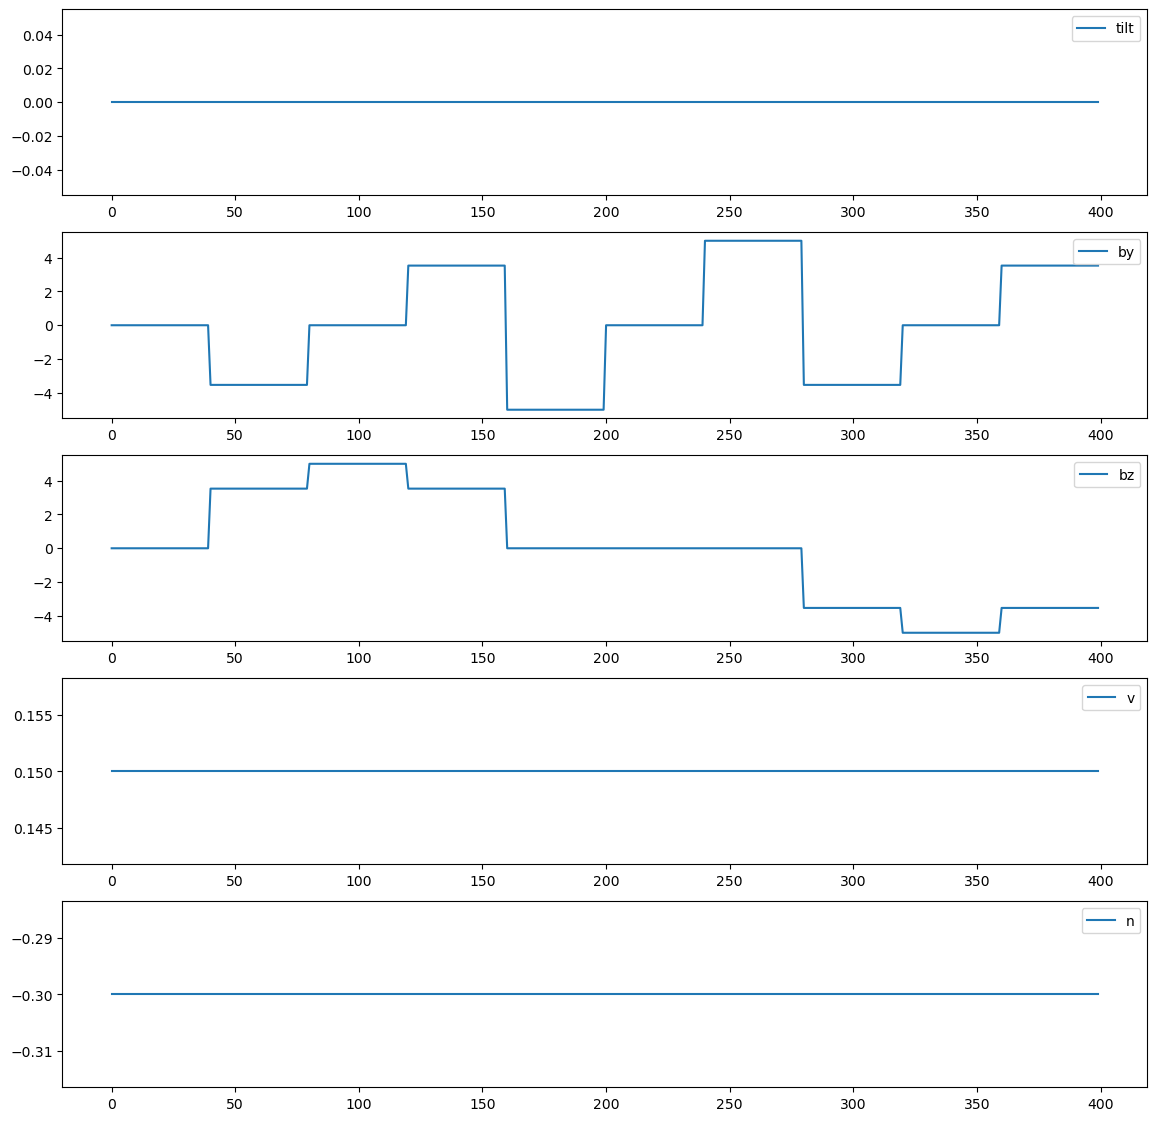

In [6]:
#synthetic solar wind

bz=np.zeros(40)
by=np.zeros(40)
for i in  range(0,9):
    if i == 0:
        by0=np.zeros(40)-3.53
        bz0=np.zeros(40)+3.53
    if i == 1:
        by0=np.zeros(40)
        bz0=np.zeros(40)+5.0
    if i == 2:
        by0=np.zeros(40)+3.53
        bz0=np.zeros(40)+3.53
    if i == 3:
        by0=np.zeros(40)-5.0
        bz0=np.zeros(40)+.0
    if i == 4:
        by0=np.zeros(40)
        bz0=np.zeros(40)
    if i == 5:
        by0=np.zeros(40)+5.0
        bz0=np.zeros(40)
    if i == 6:
        by0=np.zeros(40)-3.53
        bz0=np.zeros(40)-3.53
    if i == 7:
        by0=np.zeros(40)
        bz0=np.zeros(40)-5.0
    if i == 8:
        by0=np.zeros(40)+3.53
        bz0=np.zeros(40)-3.53

    by=np.append(by,by0)
    bz=np.append(bz,bz0)

tlt2=np.zeros(40*10)
byp2=by
bzp2=bz
vvp2=np.zeros(40*10)+0.15 #450 km
nnp2=np.zeros(40*10)-0.3 #5 /cc

fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(511)
ax1.plot(tlt2, label='tilt')
ax1.legend()

ax2 = fig.add_subplot(512)
ax2.plot(byp2, label='by')
ax2.legend()

ax3 = fig.add_subplot(513)
ax3.plot(bzp2, label='bz')
ax3.legend() 

ax4 = fig.add_subplot(514)
ax4.plot(vvp2, label='v')
ax4.legend()

ax5 = fig.add_subplot(515)
ax5.plot(nnp2, label='n')
ax5.legend()

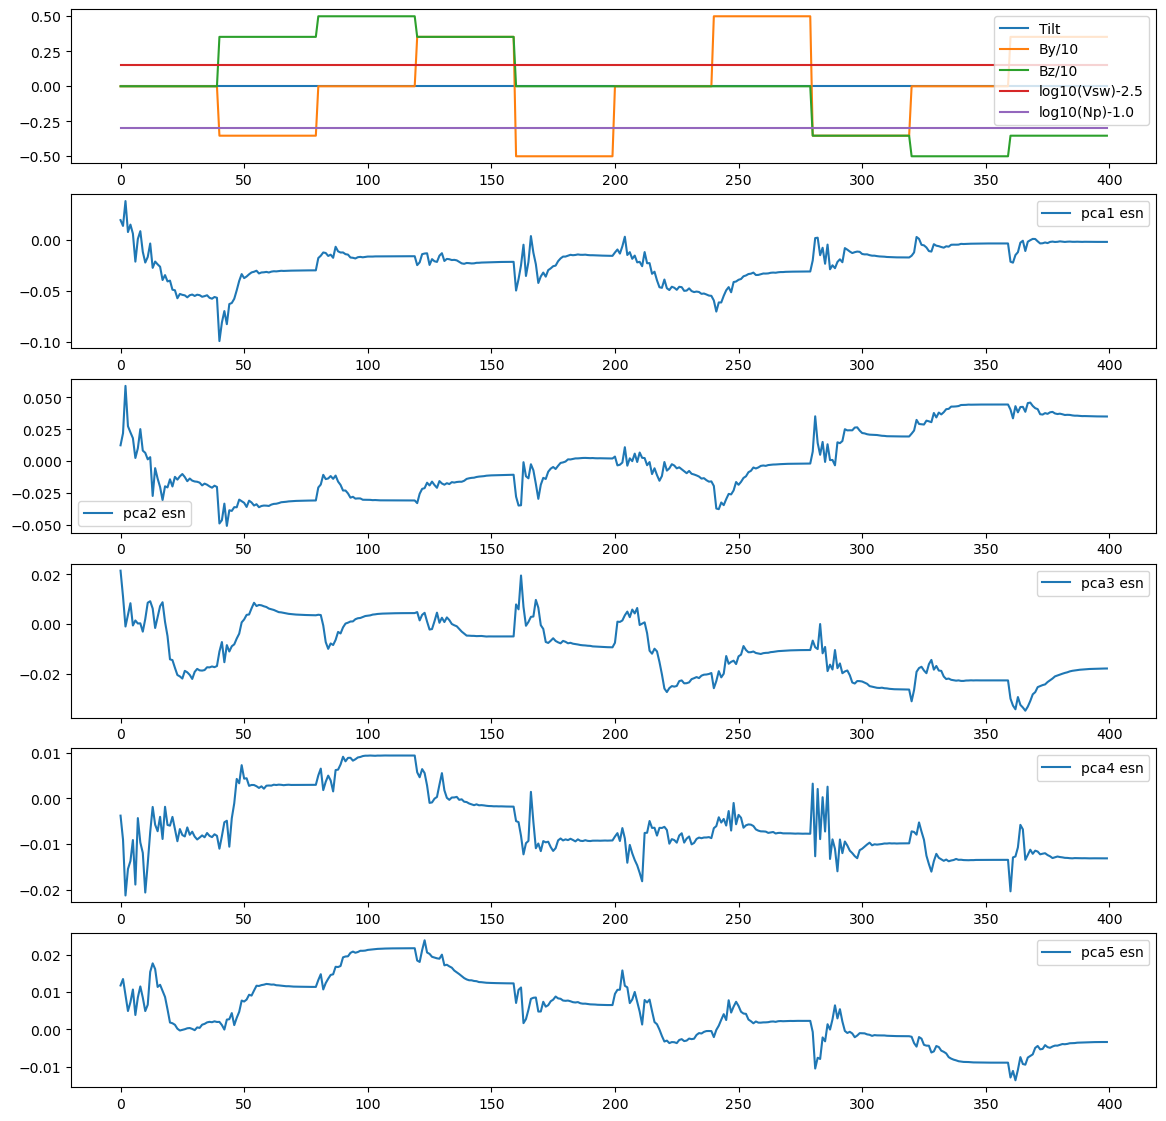

In [7]:
all10 = np.vstack((tlt2.T,byp2.T,bzp2.T,vvp2.T,nnp2.T))
data_s = all10.T

test_Y = modelw.predict(data_s)
pcap = test_Y/flearn

fig = plt.figure(figsize=(14, 14))
    
ax1 = fig.add_subplot(611)
ax1.plot(data_s[:,0], label='Tilt')
ax1.plot(data_s[:,1]/10, label='By/10')
ax1.plot(data_s[:,2]/10, label='Bz/10')
ax1.plot(data_s[:,3], label='log10(Vsw)-2.5')
ax1.plot(data_s[:,4], label='log10(Np)-1.0')
ax1.legend()

ax2 = fig.add_subplot(612)
ax2.plot(test_Y[:,0], label='pca1 esn')
ax2.legend()

ax3 = fig.add_subplot(613)
ax3.plot(test_Y[:,1], label='pca2 esn')
ax3.legend()

ax4 = fig.add_subplot(614)
ax4.plot(test_Y[:,2], label='pca3 esn')
ax4.legend()

ax5 = fig.add_subplot(615)
ax5.plot(test_Y[:,3], label='pca4 esn')
ax5.legend()

ax6 = fig.add_subplot(616)
ax6.plot(test_Y[:,4], label='pca5 esn')
ax6.legend()

plt.show()

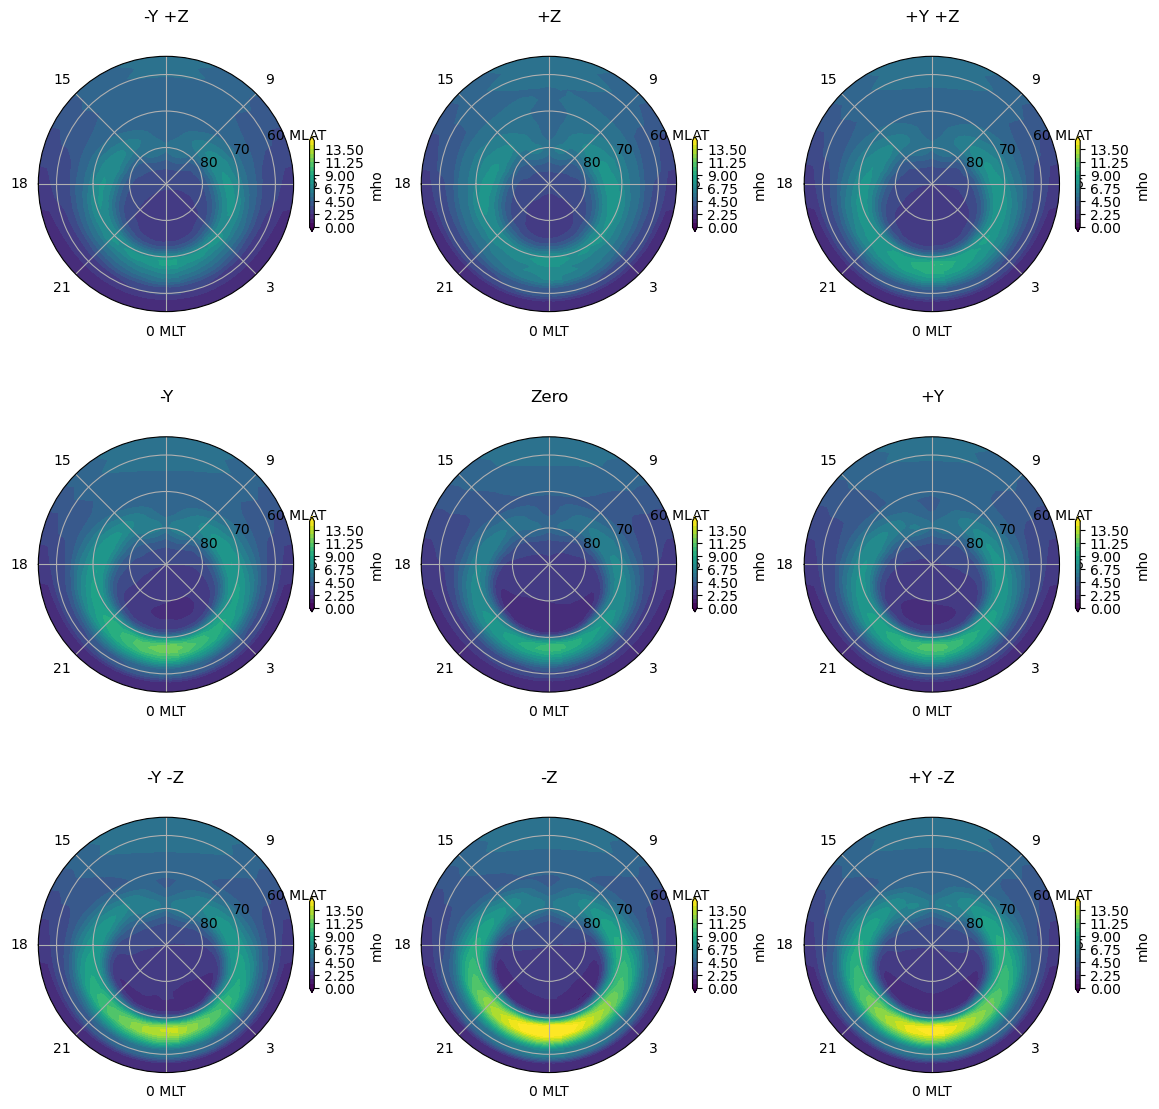

In [8]:
datpca=test_Y/flearn

w=np.dot(datpca,imgpcaw)+meanw

fig = plt.figure(figsize=(14, 14))

theta=np.array([ 0.0, 11.25, 22.5, 33.75, 45.0, 56.25, 67.5, 78.75,
       90.0, 101.25, 112.5, 123.75, 135.0, 146.25, 157.5, 168.75, 
       180.0, 191.25, 202.5, 213.75, 225.0, 236.25, 247.5, 258.75, 
       270.0, 281.25, 292.5, 303.75, 315.0, 326.25, 337.5, 348.75, 360.0])

#normal grid lon
theta=np.array([  1.688 ,   6.188 ,  10.688 ,  15.188 ,  19.688 ,  24.188 ,  28.688 ,  33.188 ,  37.688 ,  42.188,
                46.688 ,  51.188 ,  55.688 ,  60.188 ,  64.688 ,  69.188 ,  73.688 ,  78.188 ,  82.688 ,  87.188,
                91.688 ,  96.188 , 100.688 , 105.188 , 109.688 , 114.188 , 118.688 , 123.188 , 127.688 , 132.188,
                136.688 , 141.188 , 145.687 , 150.188 , 154.688 , 159.188 , 163.688 , 168.187 , 172.687 , 177.187,
                181.687 , 186.187 , 190.687 , 195.187 , 199.687 , 204.187 , 208.687 , 213.187 , 217.687 , 222.187,
                226.687 , 231.187 , 235.687 , 240.187 , 244.687 , 249.187 , 253.687 , 258.187 , 262.687 , 267.187,
                271.687 , 276.187 , 280.687 , 285.187 , 289.687 , 294.187 , 298.687 , 303.187 , 307.687 , 312.187,
                316.687 , 321.187 , 325.687 , 330.187 , 334.687 , 339.187 , 343.687 , 348.187 , 352.687 , 357.187, 367.688])

theta=theta-90.
theta=theta/360*np.pi*2

#normal grid lat north
r=np.array([53.109 ,  55.172 ,  57.234 ,  59.297 ,  61.359 ,  63.422 ,  65.484 ,  66.783 ,  67.826 ,  68.870,
            69.913 ,  70.957 ,  72.000 ,  73.044 ,  74.087 ,  75.130 ,  76.174 ,  77.217 ,  78.261 ,  79.304,
            80.348 ,  81.391 ,  82.435 ,  83.478 ,  84.522 ,  85.565 ,  86.609 ,  87.652 ,  88.696 ,  89.739])
r=90-r

tt, rr = np.meshgrid(theta,r) 

cmap0,unit0,f0,cb_min, cb_max,cb_div  ='viridis','mho',1.0, 0,15,20 #mho
interval_of_cf = np.linspace(cb_min, cb_max, cb_div+1)

iarr=np.arange(9)
ttlarr=["-Y +Z","+Z","+Y +Z","-Y","Zero","+Y","-Y -Z","-Z","+Y -Z",]

for i in iarr:

    iii=i*40+40+30
    
    ax=plt.subplot(3,3,i+1, polar=True)
    ax.set_title(ttlarr[i])
    ax.set_ylim([0,35])
    ax.set_yticks([10,20,30])
    ax.set_yticklabels(["80","70","60 MLAT"])
    ax.set_xlim([-np.pi, np.pi])
    ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax.set_xticklabels(["21", "0 MLT", "3", "6", "9", " ", "15", "18"])

    z = w[iii].reshape(30,80)*f0 #Vmho

    z2 = np.append(z, z[:, 0:1], axis=1)

    ctf = plt.contourf(tt, rr, z2,interval_of_cf, cmap=cmap0, extend="both")

    cbar=plt.colorbar(shrink=0.3,norm=ctf.norm, cmap=ctf.cmap)

    cbar.set_label(unit0)

plt.show()